#### I have used a semantic chunking strategy instead of fixed-size chunking to keep the boundaries of scientific arguments intact. The use of font-size heuristics for structure detection and embedding similarity for segmentation in this pipeline makes any retrieved chunk carry its full context devoid of ambiguity, as happens in a standard RAG implementation.


In [9]:
import os
import re
import pdfplumber
import pandas as pd
import spacy
import numpy as np
from typing import List, Dict, Tuple
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm

nlp = spacy.load("en_core_web_sm")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
class PDFParser:
    def __init__(self, file_path):
        self.file_path = file_path
        self.filename = os.path.basename(file_path)

    def extract_text_with_structure(self) -> List[Dict]:
        """
        Extracts text while attempting to identify section headers based on font size.
        Returns a list of dicts: {'text': str, 'header': str, 'page': int}
        """
        structured_content = []
        current_header = "Introduction/General"

        with pdfplumber.open(self.file_path) as pdf:
            all_chars = []
            for page in pdf.pages:
                all_chars.extend(page.chars)
            
            if not all_chars:
                return []

            font_sizes = [char['size'] for char in all_chars]
            base_font_size = max(set(font_sizes), key=font_sizes.count)
            
            print(f"Processing {self.filename}: Base font size approx {base_font_size:.2f}")

            for page_num, page in enumerate(pdf.pages):
                words = page.extract_words(extra_attrs=['size', 'fontname'])
                
                lines = {}
                
                for w in words:
                    top = round(w['top'])
                    if top not in lines:
                        lines[top] = []
                    lines[top].append(w)
                
                sorted_lines = sorted(lines.keys())
                
                for top in sorted_lines:
                    line_words = lines[top]
                    avg_size = sum([w['size'] for w in line_words]) / len(line_words)
                    line_text = " ".join([w['text'] for w in line_words])
                    
                    is_header = False
                    if avg_size > base_font_size * 1.1:
                        is_header = True
                    elif re.match(r'^(Abstract|Introduction|Results|Discussion|Methods|References|Conclusion)', line_text, re.IGNORECASE):
                        is_header = True
                    
                    if is_header:
                        current_header = line_text
                    else:
                        structured_content.append({
                            'text': line_text,
                            'header': current_header,
                            'page': page_num + 1,
                            'source': self.filename
                        })
                        
        return structured_content

    def clean_text(self, text):
        text = re.sub(r'\[\d+(?:-\d+)?\]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

In [ ]:
class SemanticChunker:
    def __init__(self, content_list, max_chunk_size=1000, similarity_threshold=0.6):
        self.content = content_list
        self.max_chunk_size = max_chunk_size
        self.similarity_threshold = similarity_threshold

    def create_chunks(self):
        chunks = []
        
        df = pd.DataFrame(self.content)
        if df.empty: return []
        
        grouped = df.groupby(['source', 'header'])
        
        for (source, header), group in tqdm(grouped, desc="Processing Sections"):
            section_text = " ".join(group['text'].tolist())
            
            doc = nlp(section_text)
            sentences = [sent.text.strip() for sent in doc.sents if len(sent.text.strip()) > 10]
            
            if not sentences:
                continue

            embeddings = embedding_model.encode(sentences)
            
            current_chunk_sents = [sentences[0]]
            current_chunk_len = len(sentences[0])
            
            for i in range(1, len(sentences)):
                sent = sentences[i]
                
                sim = cosine_similarity([embeddings[i]], [embeddings[i-1]])[0][0]
                
                if sim < self.similarity_threshold or (current_chunk_len + len(sent)) > self.max_chunk_size:
                    chunk_text = " ".join(current_chunk_sents)
                    
                    enriched_text = f"Source: {source} | Section: {header} | Content: {chunk_text}"
                    
                    chunks.append({
                        "chunk_id": len(chunks),
                        "source": source,
                        "header": header,
                        "text": chunk_text,
                        "enriched_text": enriched_text,
                        "length": len(chunk_text)
                    })
                    
                    current_chunk_sents = [sent]
                    current_chunk_len = len(sent)
                else:
                    current_chunk_sents.append(sent)
                    current_chunk_len += len(sent)
            
            if current_chunk_sents:
                chunk_text = " ".join(current_chunk_sents)
                enriched_text = f"Source: {source} | Section: {header} | Content: {chunk_text}"
                chunks.append({
                    "chunk_id": len(chunks),
                    "source": source,
                    "header": header,
                    "text": chunk_text,
                    "enriched_text": enriched_text,
                    "length": len(chunk_text)
                })
                
        return chunks

In [ ]:
pdf_files = [
    "40478_2019_Article_712.pdf", 
    "feature-context-dependency-and-complexity-reduction.pdf", 
    "GSE100233_gkx1192_supp.pdf", 
    "taf6delta-controls-apoptosis-and-gene-expression.pdf",
    "inhibition-of-mitochondrial-respiration-prevents-braf.pdf",
    "1471-2199-11-10.pdf"
]

all_chunks = []

print("Starting RAG Chunking Pipeline...")

for pdf_file in pdf_files:
    if os.path.exists(pdf_file):
        parser = PDFParser(pdf_file)
        structured_data = parser.extract_text_with_structure()
        
        chunker = SemanticChunker(
            structured_data, 
            max_chunk_size=1500,
            similarity_threshold=0.5
        )
        file_chunks = chunker.create_chunks()
        all_chunks.extend(file_chunks)
        print(f"Completed {pdf_file}: Created {len(file_chunks)} chunks.")
    else:
        print(f"Warning: File {pdf_file} not found. Skipped.")

df_chunks = pd.DataFrame(all_chunks)

print(f"\nTotal Chunks Created: {len(df_chunks)}")

Starting RAG Chunking Pipeline...
Processing 40478_2019_Article_712.pdf: Base font size approx 9.80


Processing Sections:   0%|          | 0/12 [00:00<?, ?it/s]

Completed 40478_2019_Article_712.pdf: Created 635 chunks.
Processing GSE100233_gkx1192_supp.pdf: Base font size approx 11.04


Processing Sections:   0%|          | 0/2 [00:00<?, ?it/s]

Completed GSE100233_gkx1192_supp.pdf: Created 242 chunks.


Cannot set non-stroke color because 2 components are specified but only 1 (grayscale), 3 (rgb) and 4 (cmyk) are supported
Cannot set non-stroke color because 2 components are specified but only 1 (grayscale), 3 (rgb) and 4 (cmyk) are supported
Cannot set non-stroke color because 2 components are specified but only 1 (grayscale), 3 (rgb) and 4 (cmyk) are supported
Cannot set non-stroke color because 2 components are specified but only 1 (grayscale), 3 (rgb) and 4 (cmyk) are supported


Processing 1471-2199-11-10.pdf: Base font size approx 9.76


Processing Sections:   0%|          | 0/41 [00:00<?, ?it/s]

Completed 1471-2199-11-10.pdf: Created 467 chunks.

Total Chunks Created: 1344


--- Data Quality Report ---
Total Chunks: 1344

Unique Sections Detected: 38
Top 5 Detected Headers:
header
References                                        276
Introduction                                      241
Introduction/General                              232
Results                                           120
Methods Microarray Analysis of Gene Expression     91
Name: count, dtype: int64

Chunk Length Statistics (Characters):
count    1344.000000
mean      153.069196
std       187.550211
min        11.000000
25%        51.000000
50%        96.500000
75%       187.000000
max      2651.000000
Name: length, dtype: float64


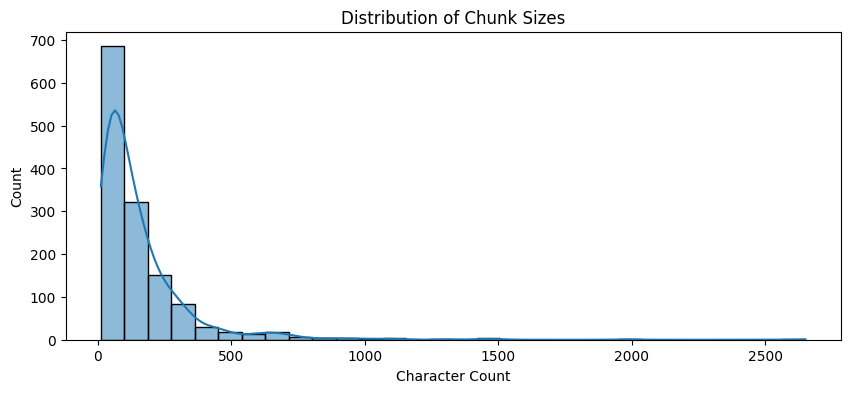


Potential Noise Chunks (<50 chars): 328
Example Noise: [19, 33, 38, 61].


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def verify_data_quality(df):
    print(f"--- Data Quality Report ---")
    print(f"Total Chunks: {len(df)}")
    
    header_counts = df['header'].value_counts()
    print(f"\nUnique Sections Detected: {len(header_counts)}")
    print("Top 5 Detected Headers:")
    print(header_counts.head(5))
    
    print(f"\nChunk Length Statistics (Characters):")
    print(df['length'].describe())
    
    plt.figure(figsize=(10, 4))
    sns.histplot(df['length'], bins=30, kde=True)
    plt.title("Distribution of Chunk Sizes")
    plt.xlabel("Character Count")
    plt.show()
    
    noise_chunks = df[df['length'] < 50]
    print(f"\nPotential Noise Chunks (<50 chars): {len(noise_chunks)}")
    if not noise_chunks.empty:
        print("Example Noise:", noise_chunks.iloc[0]['text'])

verify_data_quality(df_chunks)

In [ ]:
def simulate_rag_retrieval(query, dataframe, top_k=3):
    """
    Simulates the 'Retrieve' step of RAG to test chunk quality.
    """
    query_embedding = embedding_model.encode([query])
    
    chunk_embeddings = embedding_model.encode(dataframe['enriched_text'].tolist())
    
    similarities = cosine_similarity(query_embedding, chunk_embeddings)[0]
    
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    
    print(f"\n🔎 QUERY: '{query}'")
    print("-" * 50)
    
    for idx in top_indices:
        match = dataframe.iloc[idx]
        score = similarities[idx]
        print(f"Score: {score:.4f} | Source: {match['source']}")
        print(f"Context: [{match['header']}]")
        print(f"Text: {match['text'][:200]}...")
        print("-" * 30)

test_queries = [
    "Does Beta-sitosterol cross the blood-brain barrier?",
    "What is the role of TAF68 in apoptosis?",
    "How does mitochondrial respiration affect melanoma?"
]

for q in test_queries:
    simulate_rag_retrieval(q, df_chunks)


🔎 QUERY: 'Does Beta-sitosterol cross the blood-brain barrier?'
--------------------------------------------------
Score: 0.6284 | Source: 40478_2019_Article_712.pdf
Context: [Conclusions]
Text: patients or in patients with limited brain involvement n β injectionsof0.1mLvehicle(oliveoil; =10)or -sitosterol5mg/kg...
------------------------------
Score: 0.5994 | Source: 40478_2019_Article_712.pdf
Context: [Discussion]
Text: β -sitosterol (and its ester) on hypercholesterolemia, but environment...
------------------------------
Score: 0.5961 | Source: 40478_2019_Article_712.pdf
Context: [Discussion]
Text: β -sitosterol can be given daily to patients without side peutics and provide protection against oxidative damage effects[30]....
------------------------------

🔎 QUERY: 'What is the role of TAF68 in apoptosis?'
--------------------------------------------------
Score: 0.7890 | Source: 1471-2199-11-10.pdf
Context: [Conclusion: Together our data define a TAF6 -driven apoptotic gene expr

In [ ]:
import os
from openai import OpenAI
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

os.environ["OPENAI_API_KEY"] = "" 

client = OpenAI()

def ask_rag_system(query, dataframe, top_k=5, model="gpt-4"):
    """
    1. Retrieves relevant semantic chunks.
    2. Constructs a context-aware prompt.
    3. Generates an answer using OpenAI GPT-4.
    """
    print(f"🔎 Retrieving context for: '{query}'...")
    
    query_embedding = embedding_model.encode([query])
    
    chunk_embeddings = embedding_model.encode(dataframe['enriched_text'].tolist())
    
    similarities = cosine_similarity(query_embedding, chunk_embeddings)[0]
    
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    
    context_text = ""
    sources_metadata = set()
    
    for idx in top_indices:
        match = dataframe.iloc[idx]
        snippet = f"""
        [SOURCE]: {match['source']}
        [SECTION]: {match['header']}
        [CONTENT]: {match['text']}
        """
        context_text += snippet + "\n---\n"
        sources_metadata.add(f"{match['source']}")

    system_prompt = """
    You are a Research Assistant for a scientific review. 
    1. Answer the user's question using ONLY the provided [CONTENT] blocks.
    2. If the answer requires combining information from multiple sources, explicitly synthesize them.
    3. Cite your sources in your answer using the format: (Filename, Section).
    4. If the answer is not in the context, state "I cannot find this information in the provided documents."
    """

    user_message = f"""
    Context Information:
    {context_text}

    User Question: {query}
    """
    
    print(f"\n[DEBUG] System Prompt: {system_prompt.strip()[:100]}...")
    print(f"[DEBUG] Context Length: {len(context_text)} characters")
    print(f"[DEBUG] Sources Found: {sources_metadata}")

    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_message}
            ],
            temperature=0.2
        )
        
        answer = response.choices[0].message.content
        
        print("\n" + "="*50)
        print(f"🤖 GPT-4 ANSWER:")
        print("="*50)
        print(answer)
        print("\n" + "-"*50)
        
        return answer
        
    except Exception as e:
        print(f"Error communicating with OpenAI: {e}")
        return None

test_query = "How does Beta-sitosterol affect mitochondrial respiration and what is the mechanism?"

response = ask_rag_system(test_query, df_chunks)

🔎 Retrieving context for: 'How does Beta-sitosterol affect mitochondrial respiration and what is the mechanism?'...

[DEBUG] System Prompt: You are a Research Assistant for a scientific review. 
    1. Answer the user's question using ONLY ...
[DEBUG] Context Length: 2084 characters
[DEBUG] Sources Found: {'40478_2019_Article_712.pdf'}

🤖 GPT-4 ANSWER:
Beta-sitosterol inhibits mitochondrial respiration in tumor cells by acting as a Complex I (CI) inhibitor (40478_2019_Article_712.pdf, Results). This compound strongly reduces basal mitochondrial respiration and respiratory capacity (40478_2019_Article_712.pdf, Results). The inhibitory effect of beta-sitosterol on mitochondrial respiration is directly linked to its interaction with proteins related to apoptosis and cholesterol homeostasis (40478_2019_Article_712.pdf, Results). Furthermore, beta-sitosterol can incorporate into the inner mitochondrial membrane where it increases membrane fluidity (40478_2019_Article_712.pdf, Discussion). T